### Preprocessing

In [1]:
# Import the necessary libraries
from PIL import Image
import numpy as np
import cv2
import os
import dlib
import matplotlib.pyplot as plt
from imutils import face_utils
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
import pandas as pd

In [2]:
# Path ke folder 300_wr di Google Drive
folder_path = '300_wr'

# Dapatkan daftar semua file dalam folder
file_list = os.listdir(folder_path)
image_files = [f for f in file_list if f.endswith(('.jpg', '.png', '.jpeg'))]

In [3]:
all_images = []
for image_file in image_files: # Cek semua file gambar dalam folder
    image_path = os.path.join(folder_path, image_file)

    # Buka gambar menggunakan PIL dan konversi ke array NumPy
    image = Image.open(image_path)
    image_array = np.array(image)
    all_images.append(image_array)

In [4]:

# # Fungsi untuk augmentasi flip
def augment_image_flip_only(image):
    augmented_images = []

    # Flip horizontal
    flipped_horizontally = np.fliplr(image)
    augmented_images.append(flipped_horizontally)


    return augmented_images

augmented_dataset = []

for image in all_images:
    # Tambahkan gambar asli ke dataset augmentasi
    augmented_dataset.append(image)

    # Tambahkan hasil augmentasi flip
    augmented_dataset.extend(augment_image_flip_only(image))


print(f"Jumlah gambar setelah augmentasi: {len(augmented_dataset)}")



Jumlah gambar setelah augmentasi: 600


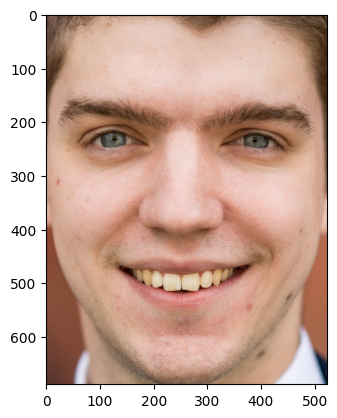

In [10]:
import matplotlib.pyplot as plt
plt.imshow(augmented_dataset[3])

In [5]:
print(f"Jumlah gambar setelah augmentasi: {len(all_images)}")


Jumlah gambar setelah augmentasi: 300


In [62]:

# Path untuk file cascade classifier

all_citraGray = []

for image in augmented_dataset:
    # Menggunakan Haar Cascade untuk mendeteksi wajah
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Konversi gambar ke grayscale untuk deteksi wajah

    # Tentukan ukuran target (misalnya, panjang sisi maksimal 224)
    target_size = 580
    
    # Hitung rasio aspect gambar asli
    height, width = gray_image.shape
    aspect_ratio = width / height

    # Tentukan dimensi baru dengan mempertahankan aspect ratio
    if aspect_ratio > 1:
        # Lebar lebih besar dari tinggi (portrait)
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        # Tinggi lebih besar atau sama dengan lebar (landscape)
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    # Resize gambar dengan ukuran yang dihitung
    resized_face = cv2.resize(gray_image, (new_width, new_height))

    # Menambahkan gambar yang telah diresize ke dalam list
    all_citraGray.append(resized_face)



In [63]:
# Path untuk file cascade classifier

all_citraasli = []

for image in augmented_dataset:
    # Menggunakan Haar Cascade untuk mendeteksi wajah

    # Tentukan ukuran target (misalnya, panjang sisi maksimal 224)
    target_size = 580
    
    # Hitung rasio aspect gambar asli
    height, width, _ = image.shape
    aspect_ratio = width / height

    # Tentukan dimensi baru dengan mempertahankan aspect ratio
    if aspect_ratio > 1:
        # Lebar lebih besar dari tinggi (portrait)
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        # Tinggi lebih besar atau sama dengan lebar (landscape)
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    # Resize gambar dengan ukuran yang dihitung
    resized_face = cv2.resize(image, (new_width, new_height))

    # Menambahkan gambar yang telah diresize ke dalam list
    all_citraasli.append(resized_face)



### Deteksi Wajah

### Ekstraksi Fitur

In [64]:

all_dahi_sections = []
all_mataT_sections = []
all_mataKr_sections = []
all_mataKn_sections = []
all_kantungKr_sections = []
all_kantungKn_sections = []
# Load the image

# Initialize dlib's face detector and create a facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_81_face_landmarks.dat")  # Download the model from dlib's website

# Iterate over each face found in the image
# Detect faces in the grayscale image

for image in all_citraGray:
    faces = detector(image)

    for face in faces:
        # Get the facial landmarks
        landmarks = predictor(image, face)
        landmarks = face_utils.shape_to_np(landmarks)
        def clip_coordinates(top, bottom, left, right):
            top = max(0, top)  # Ensure top is not less than 0
            bottom = min(height, bottom)  # Ensure bottom is not greater than the image height
            left = max(0, left)  # Ensure left is not less than 0
            right = min(width, right)  # Ensure right is not greater than the image width
            return top, bottom, left, right


        top = landmarks[68][1]  # Kelopak atas mata kiri
        bottom = landmarks[20][1]  # Kelopak bawah mata kanan
        left = landmarks[75][0]  # Sudut dalam mata kiri
        right = landmarks[74][0]  # Sudut dalam mata kanan
        top, bottom, left, right = clip_coordinates(top, bottom, left, right)

        citraDahi = np.zeros_like(image, dtype=np.float32)
        citraDahi[top:bottom, left:right] = image[top:bottom, left:right]
        all_dahi_sections.append(citraDahi)


        # Mata Tengah (middle of the eyes) menggunakan koordinat langsung
        top = landmarks[21][1]  # Kelopak atas mata kiri
        bottom = landmarks[28][1]  # Kelopak bawah mata kanan
        left = landmarks[39][0]  # Sudut dalam mata kiri
        right = landmarks[42][0]  # Sudut dalam mata kanan
        top, bottom, left, right = clip_coordinates(top, bottom, left, right)

        # Membuat citra kosong untuk area mata tengah
        citraMataT = np.zeros_like(image, dtype=np.float32)

        # Menyalin area mata tengah dari citra asli
        citraMataT[top:bottom, left:right] = image[top:bottom, left:right]
        all_mataT_sections.append(citraMataT)


        top = landmarks[77][1]  # Kelopak atas mata kiri
        bottom = landmarks[0][1]  # Kelopak bawah mata kanan
        left = landmarks[0][0]  # Sudut dalam mata kiri
        right = landmarks[18][0]  # Sudut dalam mata kanan
        top, bottom, left, right = clip_coordinates(top, bottom, left, right)

        citraMataKr = np.zeros_like(image, dtype=np.float32)
        citraMataKr[top:bottom, left:right] = image[top:bottom, left:right]
        all_mataKr_sections.append(citraMataKr)

        # Mata Kanan (right eye)
        top = landmarks[78][1]  # Kelopak atas mata kiri
        bottom = landmarks[16][1]  # Kelopak bawah mata kanan
        left = landmarks[25][0]  # Sudut dalam mata kiri
        right = landmarks[16][0]  # Sudut dalam mata kanan
        top, bottom, left, right = clip_coordinates(top, bottom, left, right)

        citraMataKn = np.zeros_like(image, dtype=np.float32)
        citraMataKn[top:bottom, left:right] = image[top:bottom, left:right]
        all_mataKn_sections.append(citraMataKn)

        # Kantung Mata Kiri (left eye bags)
        top = landmarks[41][1]
        bottom = landmarks[1][1]
        left = landmarks[1][0]
        right = landmarks[31][0]
        top, bottom, left, right = clip_coordinates(top, bottom, left, right)

        citraKantungKr = np.zeros_like(image, dtype=np.float32)
        citraKantungKr[top:bottom, left:right] = image[top:bottom, left:right]
        all_kantungKr_sections.append (citraKantungKr)


        # Kantung Mata Kanan (right eye bags)
        top = landmarks[46][1]
        bottom = landmarks[15][1]
        left = landmarks[35][0]
        right = landmarks[15][0]
        top, bottom, left, right = clip_coordinates(top, bottom, left, right)

        citraKantungKn = np.zeros_like(image, dtype=np.float32)
        citraKantungKn[top:bottom, left:right] = image[top:bottom, left:right]
        all_kantungKn_sections.append(citraKantungKn)


In [65]:
# ==================== Canny Dahi ==================== #
# 1. Canny Dahi
for idx, citraDahi in enumerate(all_dahi_sections):
    blurred_dahi = cv2.GaussianBlur(citraDahi, (5, 5), 0)

    canny_dahi = canny(blurred_dahi, sigma=1.5, low_threshold=0.1, high_threshold=0.2)

    # 2. BW LABEL DAHI
    canny_dahi_bw = canny_dahi.astype(bool)
    bw_canny, num_canny = label(canny_dahi_bw, connectivity=2, return_num=True)

    # ==================== Eliminasi Kandidat Keriput Dahi - Canny ==================== #
    # 1. Eliminasi Berdasarkan Luas dan Bentuk
    blob_measurements = regionprops(bw_canny)
    area1_dahi = np.array([blob.area for blob in blob_measurements])

    # Filter untuk blob dengan area lebih dari 100
    index_blob = np.where(area1_dahi > 85)[0]
    ambil_blob = np.isin(bw_canny, index_blob + 1)  # `+1` karena label mulai dari 1

    # Blob yang tersaring
    blob_bw = ambil_blob > 0
    labeled_blob_canny_dahi, number_of_blobs = label(blob_bw, connectivity=2, return_num=True)

    # 2. Eliminasi Area Luas
    blob_measurements_area = regionprops(labeled_blob_canny_dahi)
    area2_dahi = np.array([blob.area for blob in blob_measurements_area])

    mean_area = np.mean(area2_dahi)
    std_area = np.std(area2_dahi)

    # Filter untuk area yang lebih kecil dari 200
    index_area = np.where(area2_dahi < 100)[0]
    ambil_area_dahi = np.isin(labeled_blob_canny_dahi, index_area + 1)

    # Blob hasil filter kedua
    blob_bw_final = ambil_area_dahi > 0
    label_area_bw_dahi, number_area_bw = label(blob_bw_final, connectivity=2, return_num=True)



In [66]:
# ==================== Canny Sisi Tengah ==================== #
for idx, citraMataT in enumerate(all_mataT_sections):  # Pastikan variabel ini berbeda untuk setiap gambar

    blurred_tengah = cv2.GaussianBlur(citraMataT, (5, 5), 0)

    # 1. Canny Sisi Tengah
    canny_sisi_tengah = canny(blurred_tengah, sigma=1.5, low_threshold=0.1, high_threshold=0.2)

    # 2. BW LABEL
    canny_sisi_tengah_bw = canny_sisi_tengah.astype(bool)
    bw_sisi_t, num_canny = label(canny_sisi_tengah_bw, connectivity=2, return_num=True)

    # ==================== Eliminasi Kandidat Keriput - Canny ==================== #
    # 1. Eliminasi Berdasarkan Luas dan Bentuk (Sisi Tengah Mata)
    blob_measurements = regionprops(bw_sisi_t)
    area1_sisi_tengah = np.array([blob.area for blob in blob_measurements])

    # Filter untuk blob dengan area lebih dari 50
    index_blob = np.where(area1_sisi_tengah > 30)[0]
    ambil_blob = np.isin(bw_sisi_t, index_blob + 1)  # `+1` karena label mulai dari 1

    # Blob yang tersaring
    blob_bw = ambil_blob > 0
    labeled_blob_canny_sisi_tengah, number_of_blobs = label(blob_bw, connectivity=2, return_num=True)

    # 2. Eliminasi Area Luas
    blob_measurements_area = regionprops(labeled_blob_canny_sisi_tengah)
    area2_bt = np.array([blob.area for blob in blob_measurements_area])

    # Filter untuk area yang lebih kecil dari 30
    index_area = np.where(area2_bt < 40)[0]
    ambil_area_tengah = np.isin(labeled_blob_canny_sisi_tengah, index_area + 1)

    # Blob hasil filter kedua
    blob_bw_final = ambil_area_tengah > 0
    label_area_bw_tengah, number_area_bw = label(blob_bw_final, connectivity=2, return_num=True)



In [67]:
# ==================== Canny Sisi Mata ==================== #
# 1. Canny untuk sisi mata kiri dan kanan
for idx, (citraMataKr, citraMataKn) in enumerate(zip(all_mataKr_sections, all_mataKn_sections)):

    blurred_mata_kiri = cv2.GaussianBlur(citraMataKr, (5, 5), 0)
    blurred_mata_kanan = cv2.GaussianBlur(citraMataKn, (5, 5), 0)

    canny_mata_kiri = canny(blurred_mata_kiri, sigma=1.5, low_threshold=0.1, high_threshold=0.2)
    canny_mata_kanan = canny(blurred_mata_kanan, sigma=1.5, low_threshold=0.1, high_threshold=0.2)

    # 2. BW LABEL untuk sisi mata kiri dan kanan
    bw_canny_mata_kiri, num_canny_kiri = label(canny_mata_kiri, connectivity=2, return_num=True)
    bw_canny_mata_kanan, num_canny_kanan = label(canny_mata_kanan, connectivity=2, return_num=True)

    # ==================== Eliminasi Kandidat Keriput - Canny ==================== #
    # 1. Eliminasi Berdasarkan Luas dan Bentuk untuk Sisi Mata Kiri
    blob_measurements_kiri = regionprops(bw_canny_mata_kiri)
    area1_mata_kiri = np.array([blob.area for blob in blob_measurements_kiri])

    # Filter untuk blob dengan area lebih dari 50
    index_blob_kiri = np.where(area1_mata_kiri > 1)[0]
    ambil_blob_kiri = np.isin(bw_canny_mata_kiri, index_blob_kiri + 1)

    # Blob yang tersaring untuk mata kiri
    blob_bw_kiri = ambil_blob_kiri > 0
    labeled_blob_canny_mata_kiri, number_of_blobs_kiri = label(blob_bw_kiri, connectivity=2, return_num=True)

    # 1. Eliminasi Berdasarkan Luas dan Bentuk untuk Sisi Mata Kanan
    blob_measurements_kanan = regionprops(bw_canny_mata_kanan)
    area1_mata_kanan = np.array([blob.area for blob in blob_measurements_kanan])

    # Filter untuk blob dengan area lebih dari 50
    index_blob_kanan = np.where(area1_mata_kanan > 1)[0]
    ambil_blob_kanan = np.isin(bw_canny_mata_kanan, index_blob_kanan + 1)

    # Blob yang tersaring untuk mata kanan
    blob_bw_kanan = ambil_blob_kanan > 0
    labeled_blob_canny_mata_kanan, number_of_blobs_kanan = label(blob_bw_kanan, connectivity=2, return_num=True)

    # 2. Eliminasi Berdasarkan Luas dan Bentuk Bingkai
    # a. Sisi Mata Kiri
    blob_measurements_area_kiri = regionprops(labeled_blob_canny_mata_kiri)
    area2_mata_kiri = np.array([blob.area for blob in blob_measurements_area_kiri])

    # Filter untuk area yang lebih kecil dari 30
    index_blob_area_kiri = np.where(area2_mata_kiri < 50)[0]
    ambil_blob_area_kiri = np.isin(labeled_blob_canny_mata_kiri, index_blob_area_kiri + 1)

    # Blob hasil filter kedua untuk mata kiri
    blob_bw_final_kiri = ambil_blob_area_kiri > 0
    labeled_area_bw_mata_kiri, number_area_bw_kiri = label(blob_bw_final_kiri, connectivity=2, return_num=True)

    # b. Sisi Mata Kanan
    blob_measurements_area_kanan = regionprops(labeled_blob_canny_mata_kanan)
    area2_mata_kanan = np.array([blob.area for blob in blob_measurements_area_kanan])

    # Filter untuk area yang lebih kecil dari 30
    index_blob_area_kanan = np.where(area2_mata_kanan < 50)[0]
    ambil_blob_area_kanan = np.isin(labeled_blob_canny_mata_kanan, index_blob_area_kanan + 1)

    # Blob hasil filter kedua untuk mata kanan
    blob_bw_final_kanan = ambil_blob_area_kanan > 0
    labeled_area_bw_mata_kanan, number_area_bw_kanan = label(blob_bw_final_kanan, connectivity=2, return_num=True)




In [68]:
# ==================== Canny Kantung Mata ==================== #
# 1. Canny untuk kantung mata kiri dan kanan
for idx, (citraKantungKr, citraKantungKn) in enumerate(zip(all_kantungKr_sections, all_kantungKn_sections)):
    blurred_kantung_kiri = cv2.GaussianBlur(citraKantungKr, (5, 5), 0)
    blurred_kantung_kanan = cv2.GaussianBlur(citraKantungKn, (5, 5), 0)
    
    canny_kantung_kiri = canny(blurred_kantung_kiri, sigma=1.5, low_threshold=0.1, high_threshold=0.2)
    canny_kantung_kanan = canny(blurred_kantung_kanan, sigma=1.5, low_threshold=0.1, high_threshold=0.2)

    # 2. BW LABEL untuk kantung mata kiri dan kanan
    bw_canny_kantung_kiri, num_canny_kiri = label(canny_kantung_kiri, connectivity=2, return_num=True)
    bw_canny_kantung_kanan, num_canny_kanan = label(canny_kantung_kanan, connectivity=2, return_num=True)

    # ==================== Eliminasi Kandidat Keriput - Canny ==================== #
    # 1. Eliminasi Berdasarkan Luas dan Bentuk
    # a1. Kantung Kiri
    blob_measurements_kiri = regionprops(bw_canny_kantung_kiri)
    area1_kantung_kiri = np.array([blob.area for blob in blob_measurements_kiri])

    # Filter untuk blob dengan area lebih dari 35
    index_blob_kiri = np.where(area1_kantung_kiri > 55)[0]
    ambil_blob_kiri = np.isin(bw_canny_kantung_kiri, index_blob_kiri + 1)

    # Blob yang tersaring untuk kantung kiri
    blob_bw_kiri = ambil_blob_kiri > 0
    labeled_blob_canny_kantung_kiri, number_of_blobs_kiri = label(blob_bw_kiri, connectivity=2, return_num=True)

    # a2. Kantung Kiri, filter area lebih kecil dari 90
    blob_measurements_area_kiri = regionprops(labeled_blob_canny_kantung_kiri)
    area2_kantung_kiri = np.array([blob.area for blob in blob_measurements_area_kiri])

    index_blob_area_kiri = np.where(area2_kantung_kiri < 125)[0]
    ambil_blob_area_kiri = np.isin(labeled_blob_canny_kantung_kiri, index_blob_area_kiri + 1)

    blob_bw_final_kiri = ambil_blob_area_kiri > 0
    labeled_bw2_kantung_kiri, number_of_blobs_kiri = label(blob_bw_final_kiri, connectivity=2, return_num=True)

    # 2. Eliminasi Berdasarkan Luas dan Bentuk Bingkai
    # b1. Kantung Kanan, filter area lebih dari 20
    blob_measurements_kanan = regionprops(bw_canny_kantung_kanan)
    area1_kantung_kanan = np.array([blob.area for blob in blob_measurements_kanan])

    index_blob_kanan = np.where(area1_kantung_kanan > 20)[0]
    ambil_blob_kanan = np.isin(bw_canny_kantung_kanan, index_blob_kanan + 1)

    blob_bw_kanan = ambil_blob_kanan > 0
    labeled_blob_canny_kantung_kanan, number_of_blobs_kanan = label(blob_bw_kanan, connectivity=2, return_num=True)

    # b2. Kantung Kanan, filter area lebih dari 55
    blob_measurements_area_kanan = regionprops(labeled_blob_canny_kantung_kanan)
    area2_kantung_kanan = np.array([blob.area for blob in blob_measurements_area_kanan])

    index_blob_area_kanan = np.where(area2_kantung_kanan < 100)[0]
    ambil_blob_area_kanan = np.isin(labeled_blob_canny_kantung_kanan, index_blob_area_kanan + 1)

    blob_bw_final_area_kanan = ambil_blob_area_kanan > 0
    labeled_bw2_kantung_kanan, number_of_blobs_kanan = label(blob_bw_final_area_kanan, connectivity=2, return_num=True)

    

In [69]:
# Misalkan all_image_resized berisi daftar citra yang sudah di-resize
all_results = []  # Untuk menyimpan hasil statistik per gambar

# Daftar untuk menampung fitur per gambar
labels_to_mark = [label_area_bw_dahi, label_area_bw_tengah, labeled_area_bw_mata_kiri, labeled_area_bw_mata_kanan, labeled_bw2_kantung_kiri, labeled_bw2_kantung_kanan]

# Ambang batas untuk pelabelan berdasarkan total pixel count
thresholds = {
    'ringan': 1400,  # Ambang batas maksimal untuk wrinkle ringan
    'sedang': 1500   # Ambang batas maksimal untuk wrinkle sedang
}

# Loop untuk memproses setiap gambar dalam all_image_resized
for image_idx, resized_image_array in enumerate(all_citraasli):
    hasil = resized_image_array.copy()  # Salin citra asli untuk hasil marking
    bar, kol = resized_image_array.shape[:2]

    # Daftar variabel label dari berbagai area yang akan ditandai
    pixel_counts = []

    # Loop untuk menghitung jumlah pixel untuk setiap label
    for label_idx, label in enumerate(labels_to_mark):
        count = 0  # Counter untuk jumlah piksel bertanda pada label ini
        label = cv2.resize(label, (kol, bar), interpolation=cv2.INTER_NEAREST)

        for i in range(bar):
            for j in range(kol):
                if label[i, j] > 0:
                    count += 1  # Tambahkan ke jumlah piksel bertanda untuk label ini
        pixel_counts.append(count)  # Simpan jumlah piksel bertanda untuk label ini

    # Menghitung total piksel bertanda untuk semua label
    total_pixel_count = sum(pixel_counts)

    # **Pelabelan hanya berdasarkan total pixel count**
    if total_pixel_count <= thresholds['ringan']:
        wrinkle_label = 'wrinkle ringan'
    elif total_pixel_count <= thresholds['sedang']:
        wrinkle_label = 'wrinkle sedang'
    else:
        wrinkle_label = 'wrinkle berat'

    # Menyimpan hasil statistik untuk gambar ini
    image_results = {
        'image_idx': image_idx,
        'pixel_count_label_dahi': pixel_counts[0],
        'pixel_count_label_tengah': pixel_counts[1],
        'pixel_count_label_mata_kiri': pixel_counts[2],
        'pixel_count_label_mata_kanan': pixel_counts[3],
        'pixel_count_label_kantung_kiri': pixel_counts[4],
        'pixel_count_label_kantung_kanan': pixel_counts[5],
        'total_pixel_count': total_pixel_count,
        'label': wrinkle_label  # Label diambil dari total pixel count saja
    }

    all_results.append(image_results)

# Konversi hasil menjadi DataFrame untuk menyimpannya dalam file CSV
df = pd.DataFrame(all_results)

# Menyimpan DataFrame ke dalam CSV
df.to_csv('hasil_deteksi_kerutan_total_pixel.csv', index=False)

print("File CSV berhasil disimpan!")


File CSV berhasil disimpan!


In [70]:
# Pastikan folder untuk menyimpan gambar sudah ada, jika belum maka buat folder tersebut
output_folders = ['wrinkle_ringan', 'wrinkle_sedang', 'wrinkle_berat']
for folder in output_folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Loop untuk memproses setiap gambar dan menyimpan ke folder sesuai label
for image_idx, (resized_image_array, result) in enumerate(zip(all_citraasli, all_results)):
    # Dapatkan label dari hasil proses sebelumnya
    wrinkle_label = result['label']

    # Tentukan folder tujuan berdasarkan label
    if wrinkle_label == 'wrinkle ringan':
        folder_path = 'wrinkle_ringan'
    elif wrinkle_label == 'wrinkle sedang':
        folder_path = 'wrinkle_sedang'
    elif wrinkle_label == 'wrinkle berat':
        folder_path = 'wrinkle_berat'
    else:
        continue  # Jika label tidak sesuai, lewati gambar ini

    # Konversi gambar menjadi format RGB jika belum dalam format RGB
    if len(resized_image_array.shape) == 2 or resized_image_array.shape[2] != 3:
        resized_image_array = cv2.cvtColor(resized_image_array, cv2.COLOR_GRAY2BGR)
    else:
        # Konversi dari BGR ke RGB untuk memastikan format warna benar
        resized_image_array = cv2.cvtColor(resized_image_array, cv2.COLOR_BGR2RGB)

    # Simpan gambar ke folder yang sesuai
    output_path = os.path.join(folder_path, f'image_{image_idx}.jpg')
    cv2.imwrite(output_path, resized_image_array)

print("Gambar berhasil dikonversi ke RGB dan disimpan ke folder sesuai label!")


Gambar berhasil dikonversi ke RGB dan disimpan ke folder sesuai label!


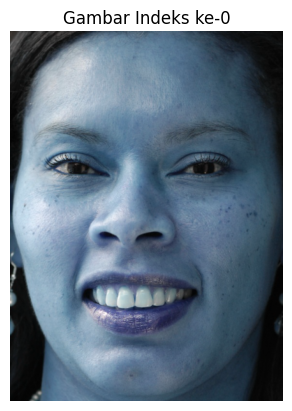

In [71]:
# Pastikan daftar all_citraasli telah diinisialisasi dengan benar
if len(all_citraasli) > 0:
    # Ambil gambar pada indeks ke-0
    gambar_index_0 = all_citraasli[0]
    
    # Tampilkan gambar menggunakan matplotlib
    plt.imshow(cv2.cvtColor(gambar_index_0, cv2.COLOR_BGR2RGB))  # Konversi BGR ke RGB untuk plotting
    plt.title("Gambar Indeks ke-0")
    plt.axis('off')  # Hilangkan sumbu
    plt.show()
else:
    print("Daftar all_citraasli kosong!")
